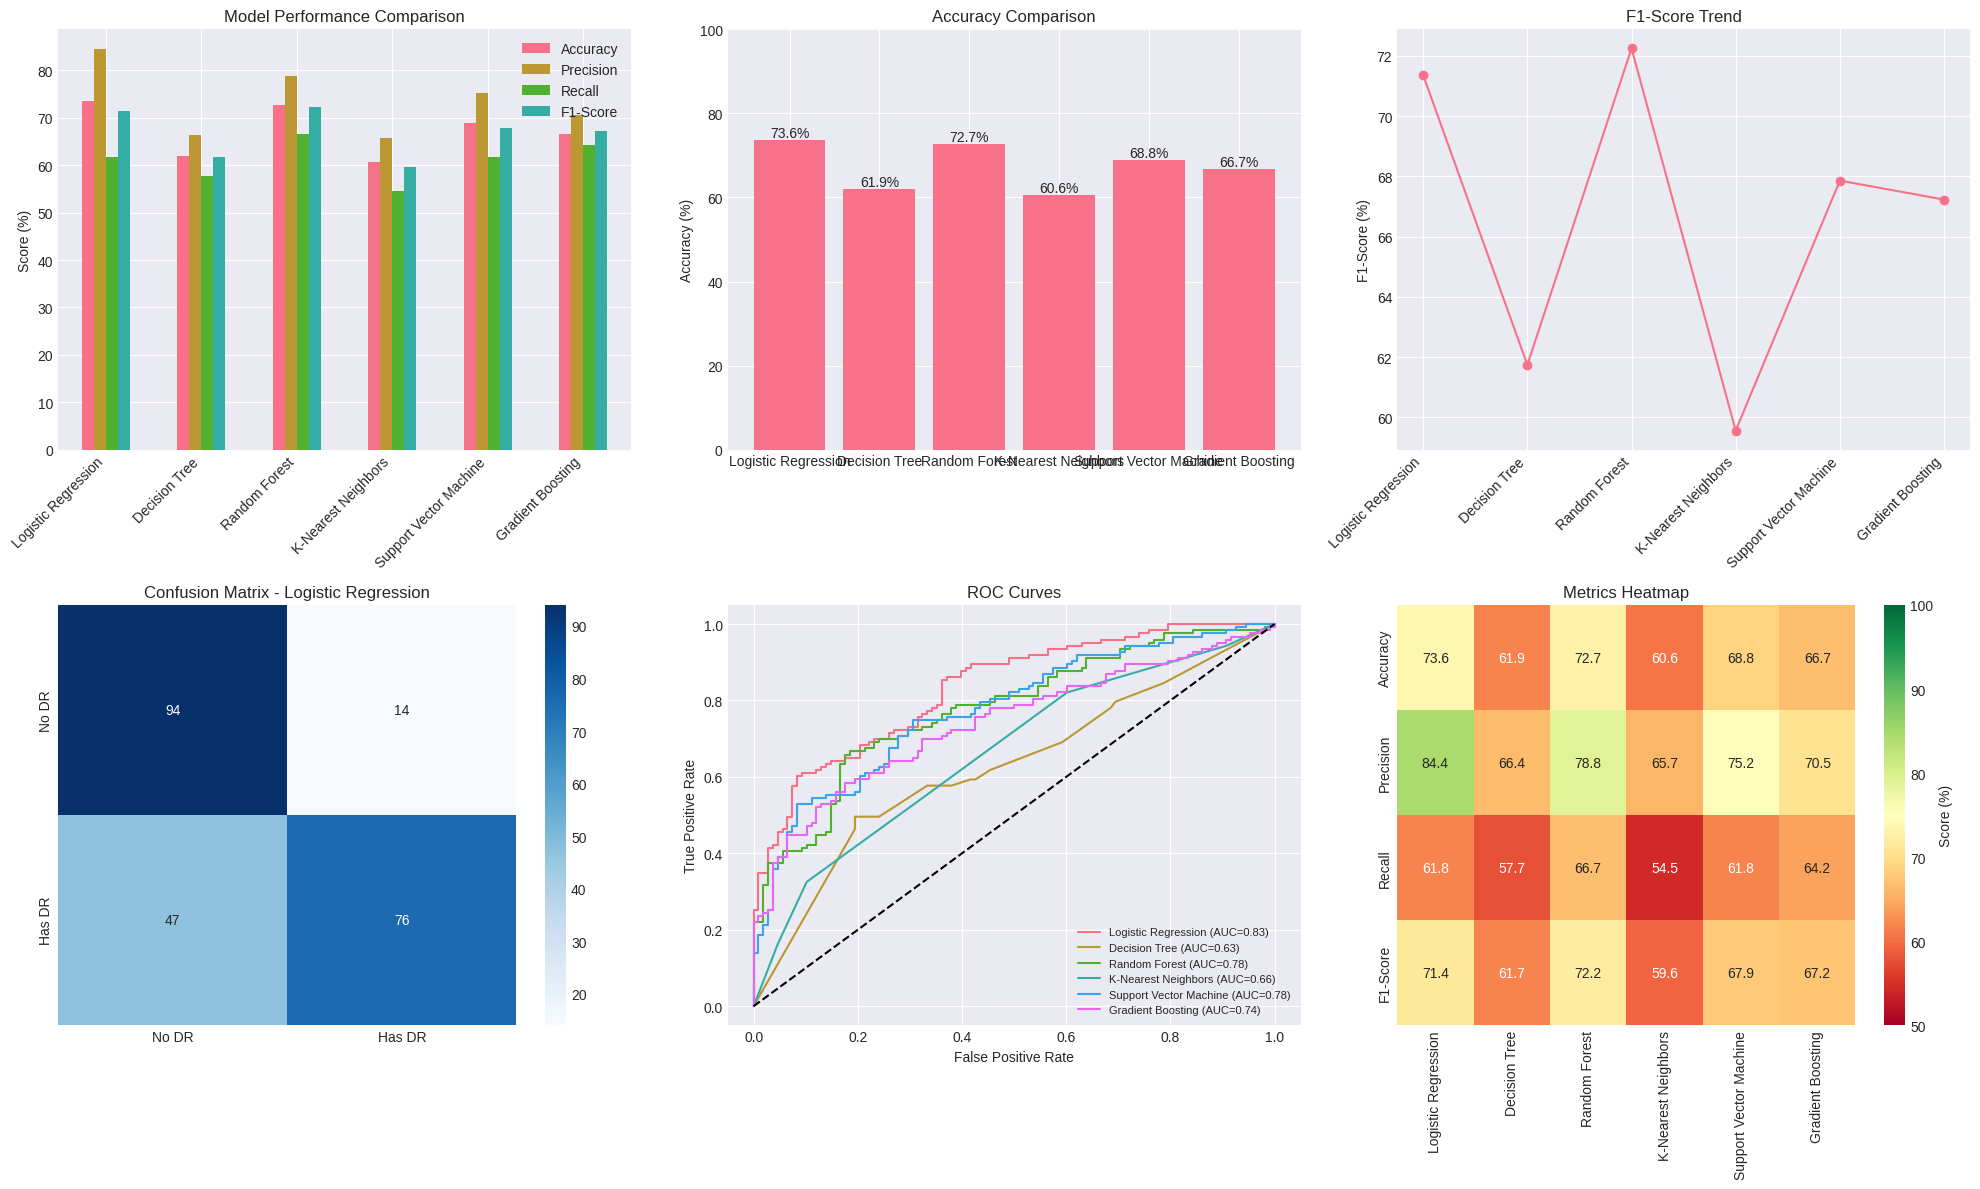


Best Model: Logistic Regression
              precision    recall  f1-score   support

   No DR (0)       0.67      0.87      0.76       108
  Has DR (1)       0.84      0.62      0.71       123

    accuracy                           0.74       231
   macro avg       0.76      0.74      0.73       231
weighted avg       0.76      0.74      0.73       231


Top 10 Features:
Feature  Importance
      2    0.103961
      8    0.087585
     14    0.076546
      3    0.068112
      9    0.065707
     16    0.065132
     11    0.064923
     10    0.061300
     17    0.053961
     15    0.053428


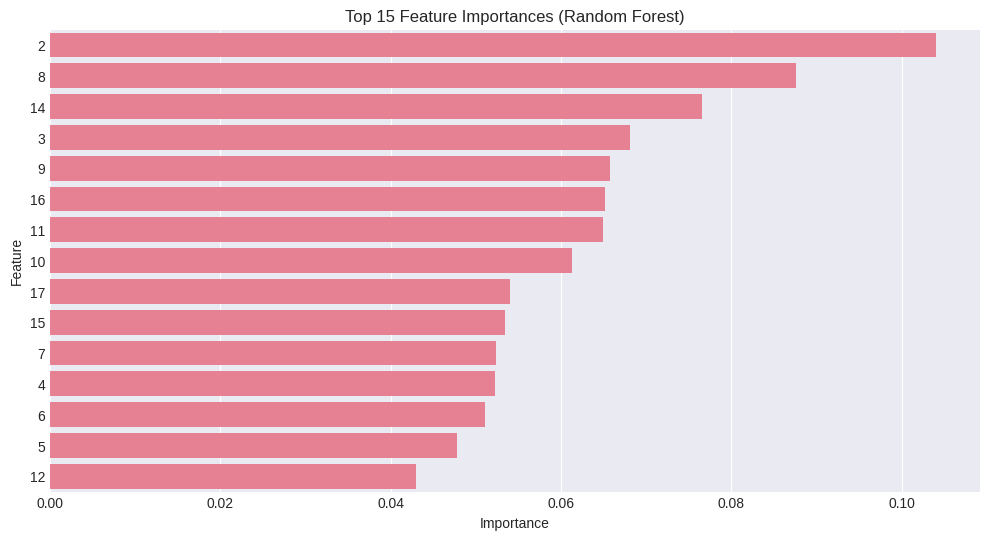

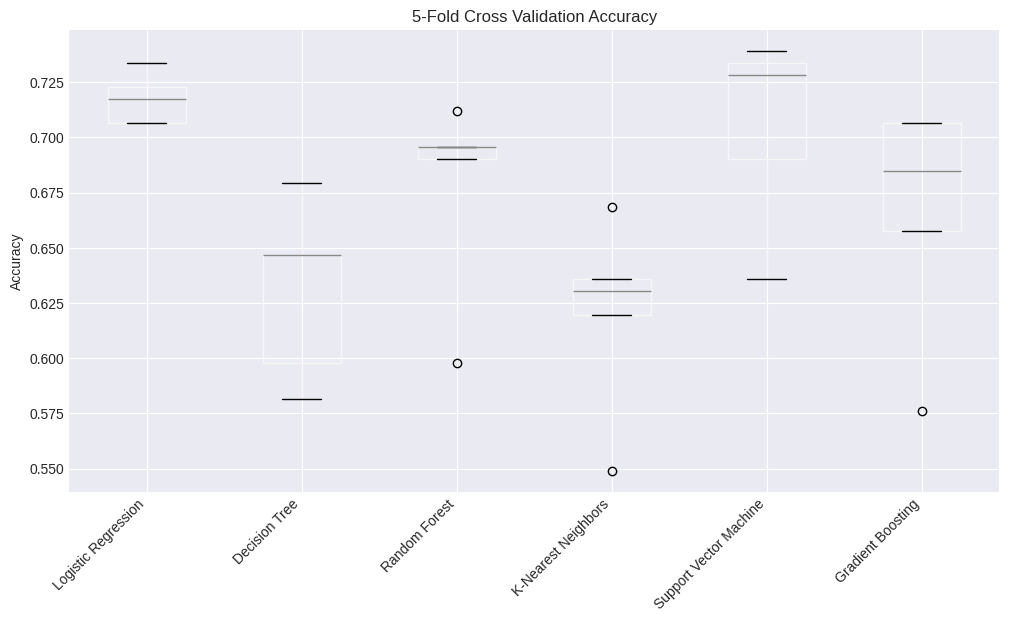

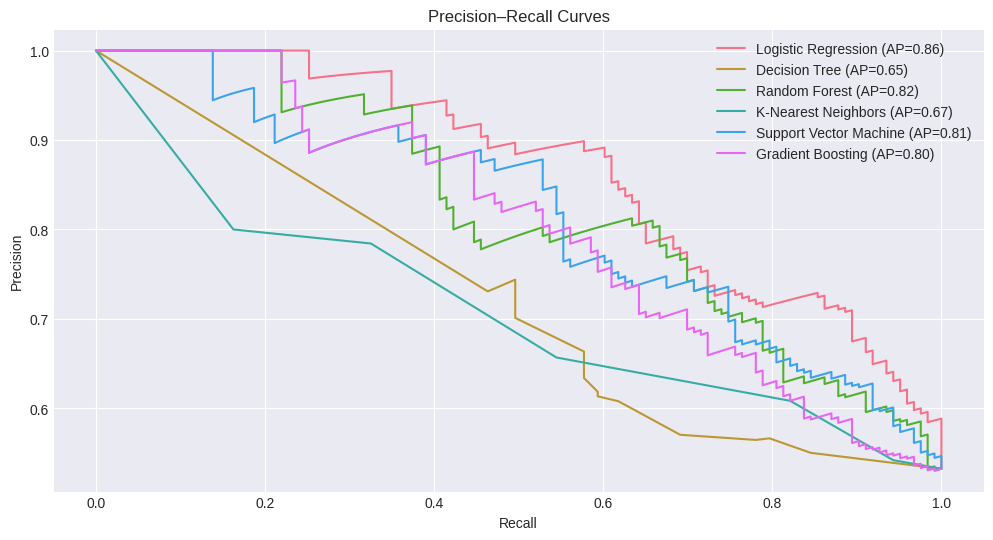

Total Models Trained: 6
Dataset Size: 1151 samples
Number of Features: 19
Test Set Size: 231 samples
Best Performing Model: Logistic Regression

Final Results:
                        Accuracy  Precision  Recall  F1-Score
Logistic Regression        73.59      84.44   61.79     71.36
Random Forest              72.73      78.85   66.67     72.25
Support Vector Machine     68.83      75.25   61.79     67.86
Gradient Boosting          66.67      70.54   64.23     67.23
Decision Tree              61.90      66.36   57.72     61.74
K-Nearest Neighbors        60.61      65.69   54.47     59.56


In [ ]:
# =========================
# Install & Imports
# =========================
!pip install scikit-learn pandas numpy matplotlib seaborn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# =========================
# Load Dataset
# =========================
url = "https://docs.google.com/spreadsheets/d/1Iwh6grSLUqESUfn6292sAALj9uw5FJV0ACJ6SPOmQQA/export?format=csv"
df = pd.read_csv(url)

# Fix target column
df["Class"] = (
    df["Class"]
    .astype(str)
    .str.replace("b'", "", regex=False)
    .str.replace("'", "", regex=False)
    .astype(int)
)

X = df.iloc[:, :-1]
y = df["Class"]

# =========================
# Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# Scaling
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# Models
# =========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel="rbf", probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
predictions = {}
probabilities = {}

# =========================
# Train & Evaluate
# =========================
for name, model in models.items():
    if name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred) * 100,
        "Precision": precision_score(y_test, y_pred, zero_division=0) * 100,
        "Recall": recall_score(y_test, y_pred, zero_division=0) * 100,
        "F1-Score": f1_score(y_test, y_pred, zero_division=0) * 100,
        "Model": model
    }

    predictions[name] = y_pred
    probabilities[name] = y_prob

# =========================
# Results DataFrame (FIXED)
# =========================
results_df = (
    pd.DataFrame(results)
    .T.drop(columns="Model")
    .apply(pd.to_numeric)     # 🔥 FIX: ensures numeric dtype
    .round(2)
)

best_model_name = results_df["Accuracy"].idxmax()

# =========================
# Visualization Dashboard
# =========================
fig = plt.figure(figsize=(20, 12))

# --- Bar Plot
ax1 = plt.subplot(2, 3, 1)
results_df.plot(kind="bar", ax=ax1)
ax1.set_title("Model Performance Comparison")
ax1.set_ylabel("Score (%)")
ax1.set_xticklabels(results_df.index, rotation=45, ha="right")

# --- Accuracy Bars
ax2 = plt.subplot(2, 3, 2)
bars = ax2.bar(results_df.index, results_df["Accuracy"])
ax2.set_title("Accuracy Comparison")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(0, 100)
for bar in bars:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{bar.get_height():.1f}%", ha="center", va="bottom")

# --- F1 Trend
ax3 = plt.subplot(2, 3, 3)
ax3.plot(results_df.index, results_df["F1-Score"], marker="o")
ax3.set_title("F1-Score Trend")
ax3.set_ylabel("F1-Score (%)")
ax3.set_xticklabels(results_df.index, rotation=45, ha="right")

# --- Confusion Matrix
ax4 = plt.subplot(2, 3, 4)
cm = confusion_matrix(y_test, predictions[best_model_name])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No DR", "Has DR"],
            yticklabels=["No DR", "Has DR"], ax=ax4)
ax4.set_title(f"Confusion Matrix - {best_model_name}")

# --- ROC Curves
ax5 = plt.subplot(2, 3, 5)
for name in models:
    fpr, tpr, _ = roc_curve(y_test, probabilities[name])
    ax5.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")
ax5.plot([0, 1], [0, 1], "k--")
ax5.set_title("ROC Curves")
ax5.set_xlabel("False Positive Rate")
ax5.set_ylabel("True Positive Rate")
ax5.legend(fontsize=8)

# --- Metrics Heatmap (FIXED)
ax6 = plt.subplot(2, 3, 6)
metrics_data = results_df[["Accuracy", "Precision", "Recall", "F1-Score"]].T

sns.heatmap(
    metrics_data,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    vmin=50,
    vmax=100,
    ax=ax6,
    cbar_kws={"label": "Score (%)"}
)

ax6.set_title("Metrics Heatmap")

plt.tight_layout()
plt.show()

# =========================
# Classification Report
# =========================
print("\nBest Model:", best_model_name)
print(classification_report(
    y_test,
    predictions[best_model_name],
    target_names=["No DR (0)", "Has DR (1)"]
))

# =========================
# Feature Importance (RF)
# =========================
rf_model = results["Random Forest"]["Model"]
feature_importance = (
    pd.DataFrame({
        "Feature": X.columns,
        "Importance": rf_model.feature_importances_
    })
    .sort_values("Importance", ascending=False)
)

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance.head(15)
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

# =========================
# Cross Validation
# =========================
cv_results = {}

for name, model in models.items():
    if name in ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_results[name] = scores

cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 6))
cv_df.boxplot()
plt.title("5-Fold Cross Validation Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.show()

# =========================
# Precision–Recall Curves
# =========================
plt.figure(figsize=(12, 6))
for name in models:
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, probabilities[name])
    ap = average_precision_score(y_test, probabilities[name])
    plt.plot(recall_vals, precision_vals, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()

# =========================
# Summary
# =========================
print(f"Total Models Trained: {len(models)}")
print(f"Dataset Size: {len(df)} samples")
print(f"Number of Features: {X.shape[1]}")
print(f"Test Set Size: {len(y_test)} samples")
print(f"Best Performing Model: {best_model_name}")
print("\nFinal Results:")
print(results_df.sort_values("Accuracy", ascending=False))

